# Unsupervied Clustering of Shoppers

The notebook aims at understanding the mac addresses using a clustering algorithm (k-means) to determine whether the mac addresses are stationary or moving (shoppers).

## Theory

Machine learning is the most common method for find clustering data into seperate groups.

Python has various packages to perform machine learning (out of the box) on a dataset. We have used these packages to determine whether they can seperate out devices (mac addresses) into shoppers and non-shoppers.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
from msci.utils import utils
from msci.utils.plot import plot_path_jn, plot_histogram_jn

## Import data

In [4]:
mac_address_df = utils.import_mac_addresses()

In [5]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

18719 mac addresses with 22 features


In [6]:
from msci.cleaning.features import *

In [7]:
signal_df = utils.import_signals(version=1)

## Investigation

In [8]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

In [9]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [10]:
# Add the arrive and leave times to the dataframe

signal_starttimes_df = signal_df[['mac_address', 'date_time']].drop_duplicates('mac_address', keep='first')
signal_endtimes_df = signal_df[['mac_address', 'date_time']].drop_duplicates('mac_address', keep='last')
mac_address_clean_df = pd.merge(mac_address_clean_df, signal_starttimes_df, how='left', on='mac_address')
mac_address_clean_df = mac_address_clean_df.rename(columns={'date_time': 'arrive_time'})
mac_address_clean_df = pd.merge(mac_address_clean_df, signal_endtimes_df, how='left', on='mac_address')
mac_address_clean_df = mac_address_clean_df.rename(columns={'date_time': 'leave_time'})

In [11]:
mac_address_clean_df.describe()

,frequency,radius_of_gyration,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,total_turning_angle,av_turning_angle_velocity,av_path_length,total_path_length,av_straightness,av_speed_from_total,turning_angle_density,shopper_probability,shopper_label
count,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000,18719.000000
mean,106.411507,62.714836,2.397377,15540.402425,0.030824,0.800902,1.614303,165.738474,-0.009903,26.641721,1820.546832,2.409488,0.217141,0.068961,0.912404,0.910813
std,217.454524,26.012149,1.431507,19336.299809,0.172846,0.820970,0.346266,407.675970,0.187453,14.556413,2909.134176,1.080225,0.206407,0.047141,0.265562,0.260361
min,11.000000,0.944355,0.000000,122.000000,0.000000,0.004872,0.084186,0.390607,-3.119614,0.183925,16.185363,1.000000,0.000194,0.001430,0.000000,0.000000
25%,25.000000,45.628666,1.312548,4018.500000,0.000000,0.429039,1.386310,30.484451,-0.045101,16.530345,762.526468,1.788631,0.090872,0.037598,0.999817,1.000000
50%,50.000000,65.970274,2.138090,7655.000000,0.000000,0.599074,1.607150,64.869140,-0.000823,22.764830,1211.447640,2.214111,0.174103,0.057431,0.999995,1.000000
75%,101.000000,81.333072,3.211864,17406.500000,0.000000,0.874614,1.830954,138.971389,0.039358,33.279112,1904.338929,2.753506,0.277631,0.085086,1.000000,1.000000
max,4078.000000,154.812502,15.556349,86335.000000,1.000000,17.016983,3.141593,8195.419843,3.049002,155.846628,138837.554597,40.620109,3.969383,0.477567,1.000000,1.000000


We need to scale each feature into a Gaussian distribution.

In [12]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [13]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### Kmeans

This is one of the simplist clusetering methods.

Each point is defined into a distinct group with no probability given. This does not allow you to remove points which which have low uncertainty.

In [14]:
n_clusters = 2

model = KMeans(n_clusters=n_clusters)
model.fit(samples)
labels = model.predict(samples)

In [15]:
mac_address_clean_df['kmeans_label'] = labels

In [16]:
mac_address_clean_df.kmeans_label.value_counts()

0    14848
1     3871
Name: kmeans_label, dtype: int64

### DBSCAN

Used to find initial estimates

In [17]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

In [117]:
db = DBSCAN(eps=0.55, min_samples=6)
db.fit(samples)
labels = db.labels_

In [120]:
mac_address_clean_df['dbscan_label'] = labels

In [121]:
mac_address_clean_df.dbscan_label.value_counts()

-1     11734
 9      6320
 2       277
 1       130
 4        37
 10       13
 5        12
 20       10
 32        9
 3         9
 15        9
 18        8
 22        7
 33        7
 12        7
 17        7
 14        7
 16        7
 11        7
 19        6
 0         6
 24        6
 13        6
 7         6
 23        6
 25        6
 37        5
 28        5
 27        5
 34        5
 6         5
 8         5
 35        5
 38        5
 29        4
 30        4
 26        3
 36        3
 21        3
 31        3
Name: dbscan_label, dtype: int64

In [134]:
DBSCAN_LABEL = 2

In [135]:
samples_1 = samples[mac_address_clean_df.dbscan_label == DBSCAN_LABEL]
samples_2 = samples[mac_address_clean_df.dbscan_label != DBSCAN_LABEL]

In [136]:
means_init = np.array([np.mean(samples_1, axis=0), np.mean(samples_2, axis=0)])
weights_init = np.array([samples_1.shape[0]/samples.shape[0], samples_2.shape[0]/samples.shape[0]])
precisions_init = np.array([np.linalg.inv(np.cov(samples_1.T)), np.linalg.inv(np.cov(samples_2.T))])

### Gaussian Mixture

This has over clustered the data.

In [137]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

In [138]:
model = GaussianMixture(n_components=2, means_init=means_init, weights_init=weights_init, precisions_init=precisions_init)
model.fit(samples)
labels = model.predict(samples)

In [139]:
mac_address_clean_df['gaussian_mixture_label'] = labels

In [140]:
mac_address_clean_df.gaussian_mixture_label.value_counts()

0    11530
1     7189
Name: gaussian_mixture_label, dtype: int64

### Naive Bayes

Works perfectly!!!!

In [141]:
from sklearn.naive_bayes import GaussianNB

In [142]:
db_labels = mac_address_clean_df.dbscan_label.as_matrix()
db_labels_test = db_labels.copy()
db_labels_test[np.where(db_labels == DBSCAN_LABEL)] = 1
db_labels_test[np.where(db_labels != DBSCAN_LABEL)] = 0


clf = GaussianNB()
clf.fit(samples, db_labels_test)
labels = clf.predict(samples)

mac_address_clean_df['naive_bayes_labels'] = labels

mac_address_clean_df.naive_bayes_labels.value_counts()

0    17907
1      812
Name: naive_bayes_labels, dtype: int64

## Distributions

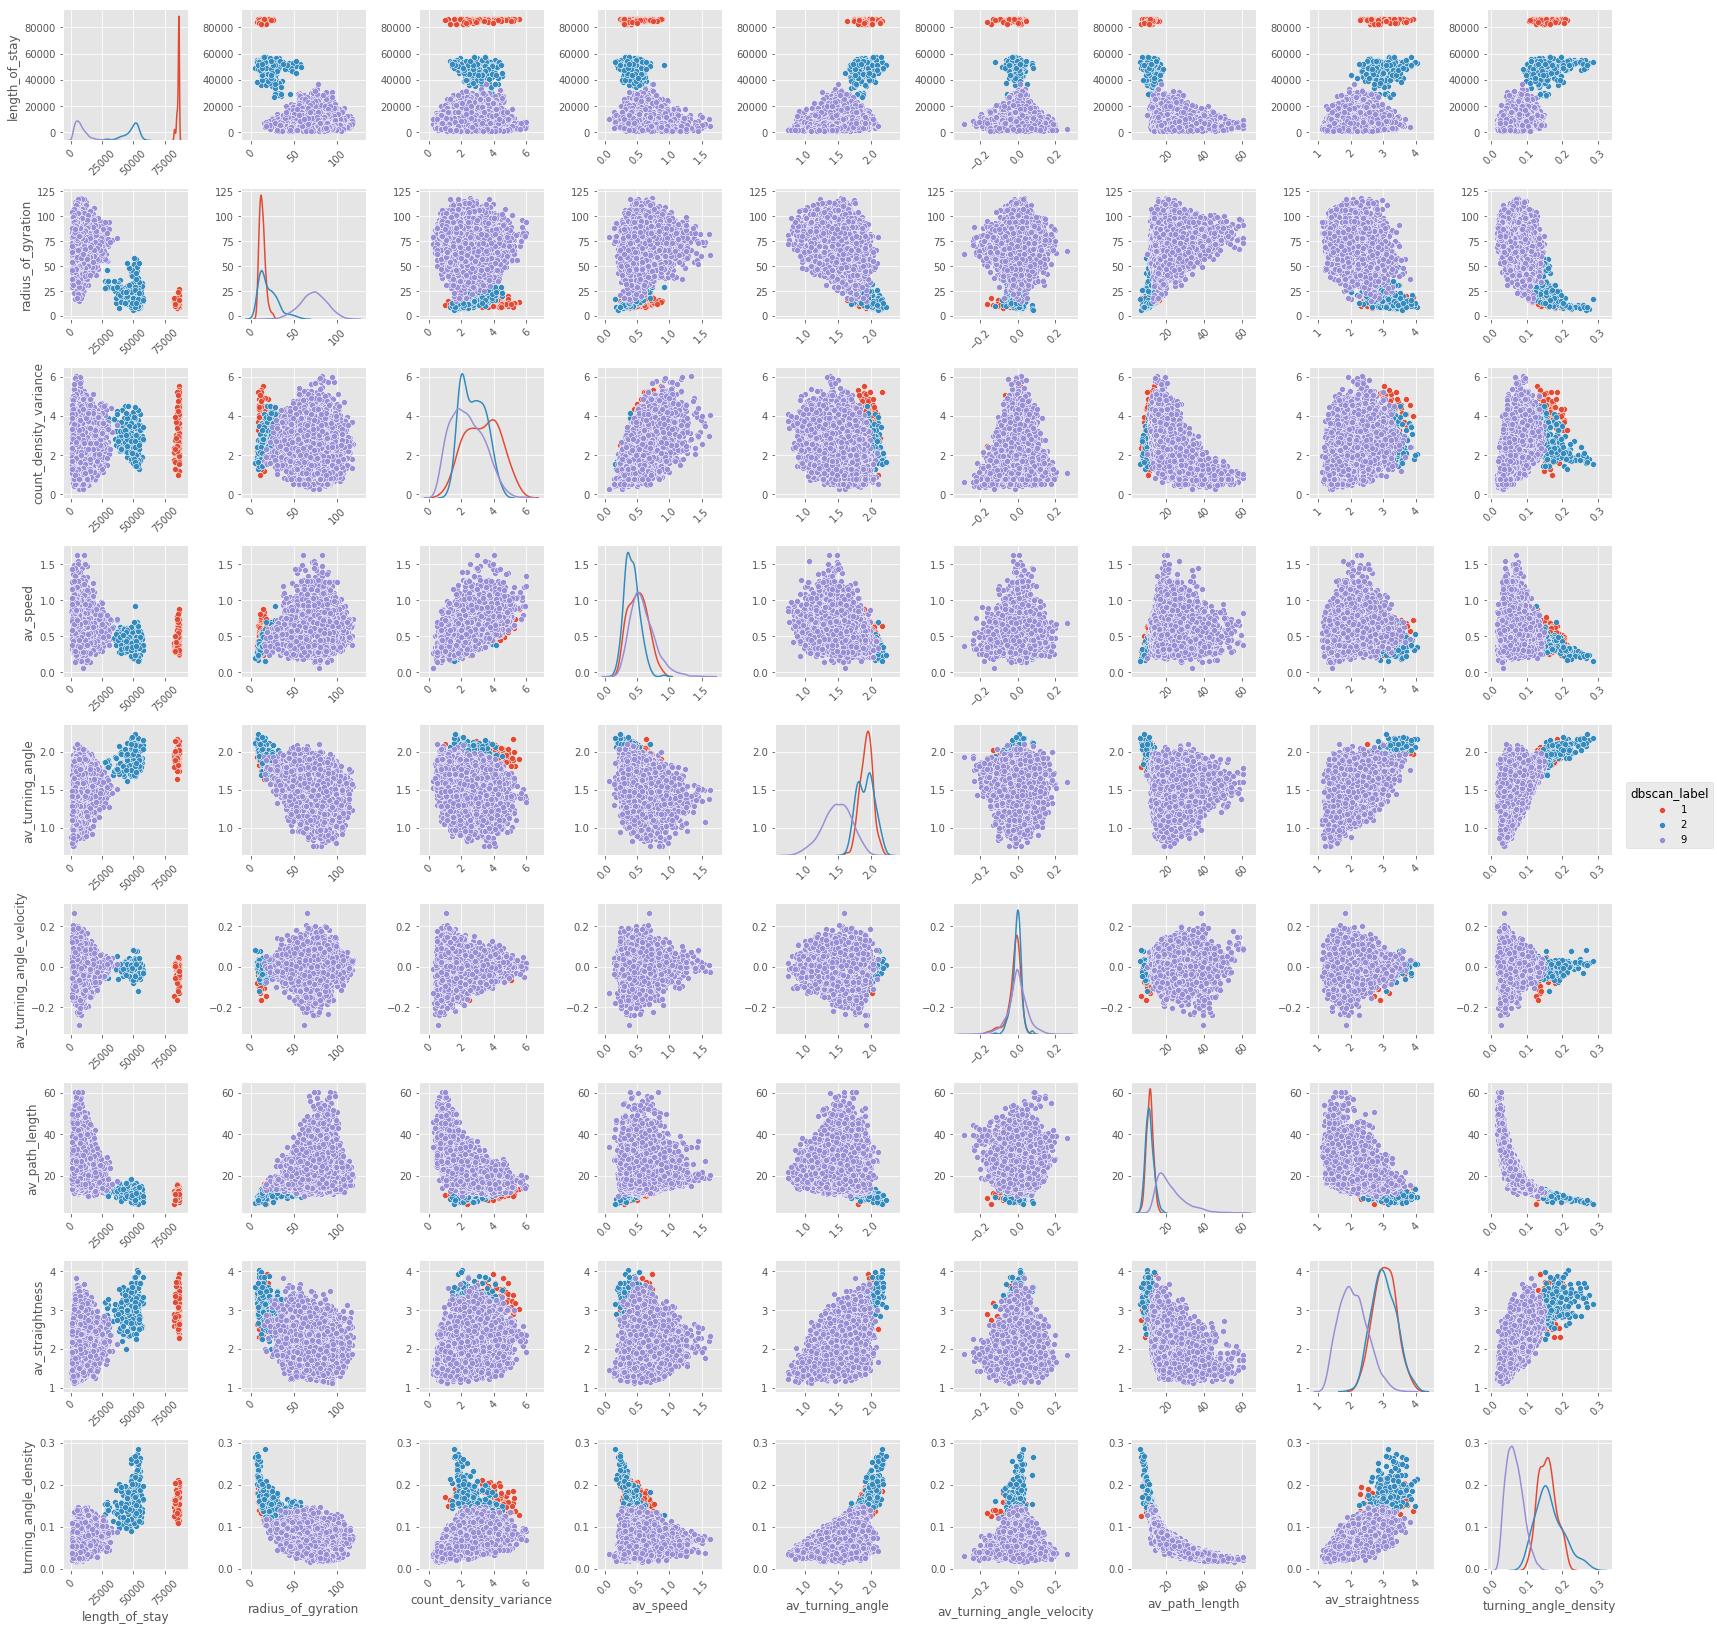

In [154]:
g = sns.pairplot(
    mac_address_clean_df[
        (mac_address_clean_df.dbscan_label==9) | 
        (mac_address_clean_df.dbscan_label==2) | 
        (mac_address_clean_df.dbscan_label==1)
    ], 
    vars=FEATURE_LIST,
    hue="dbscan_label", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

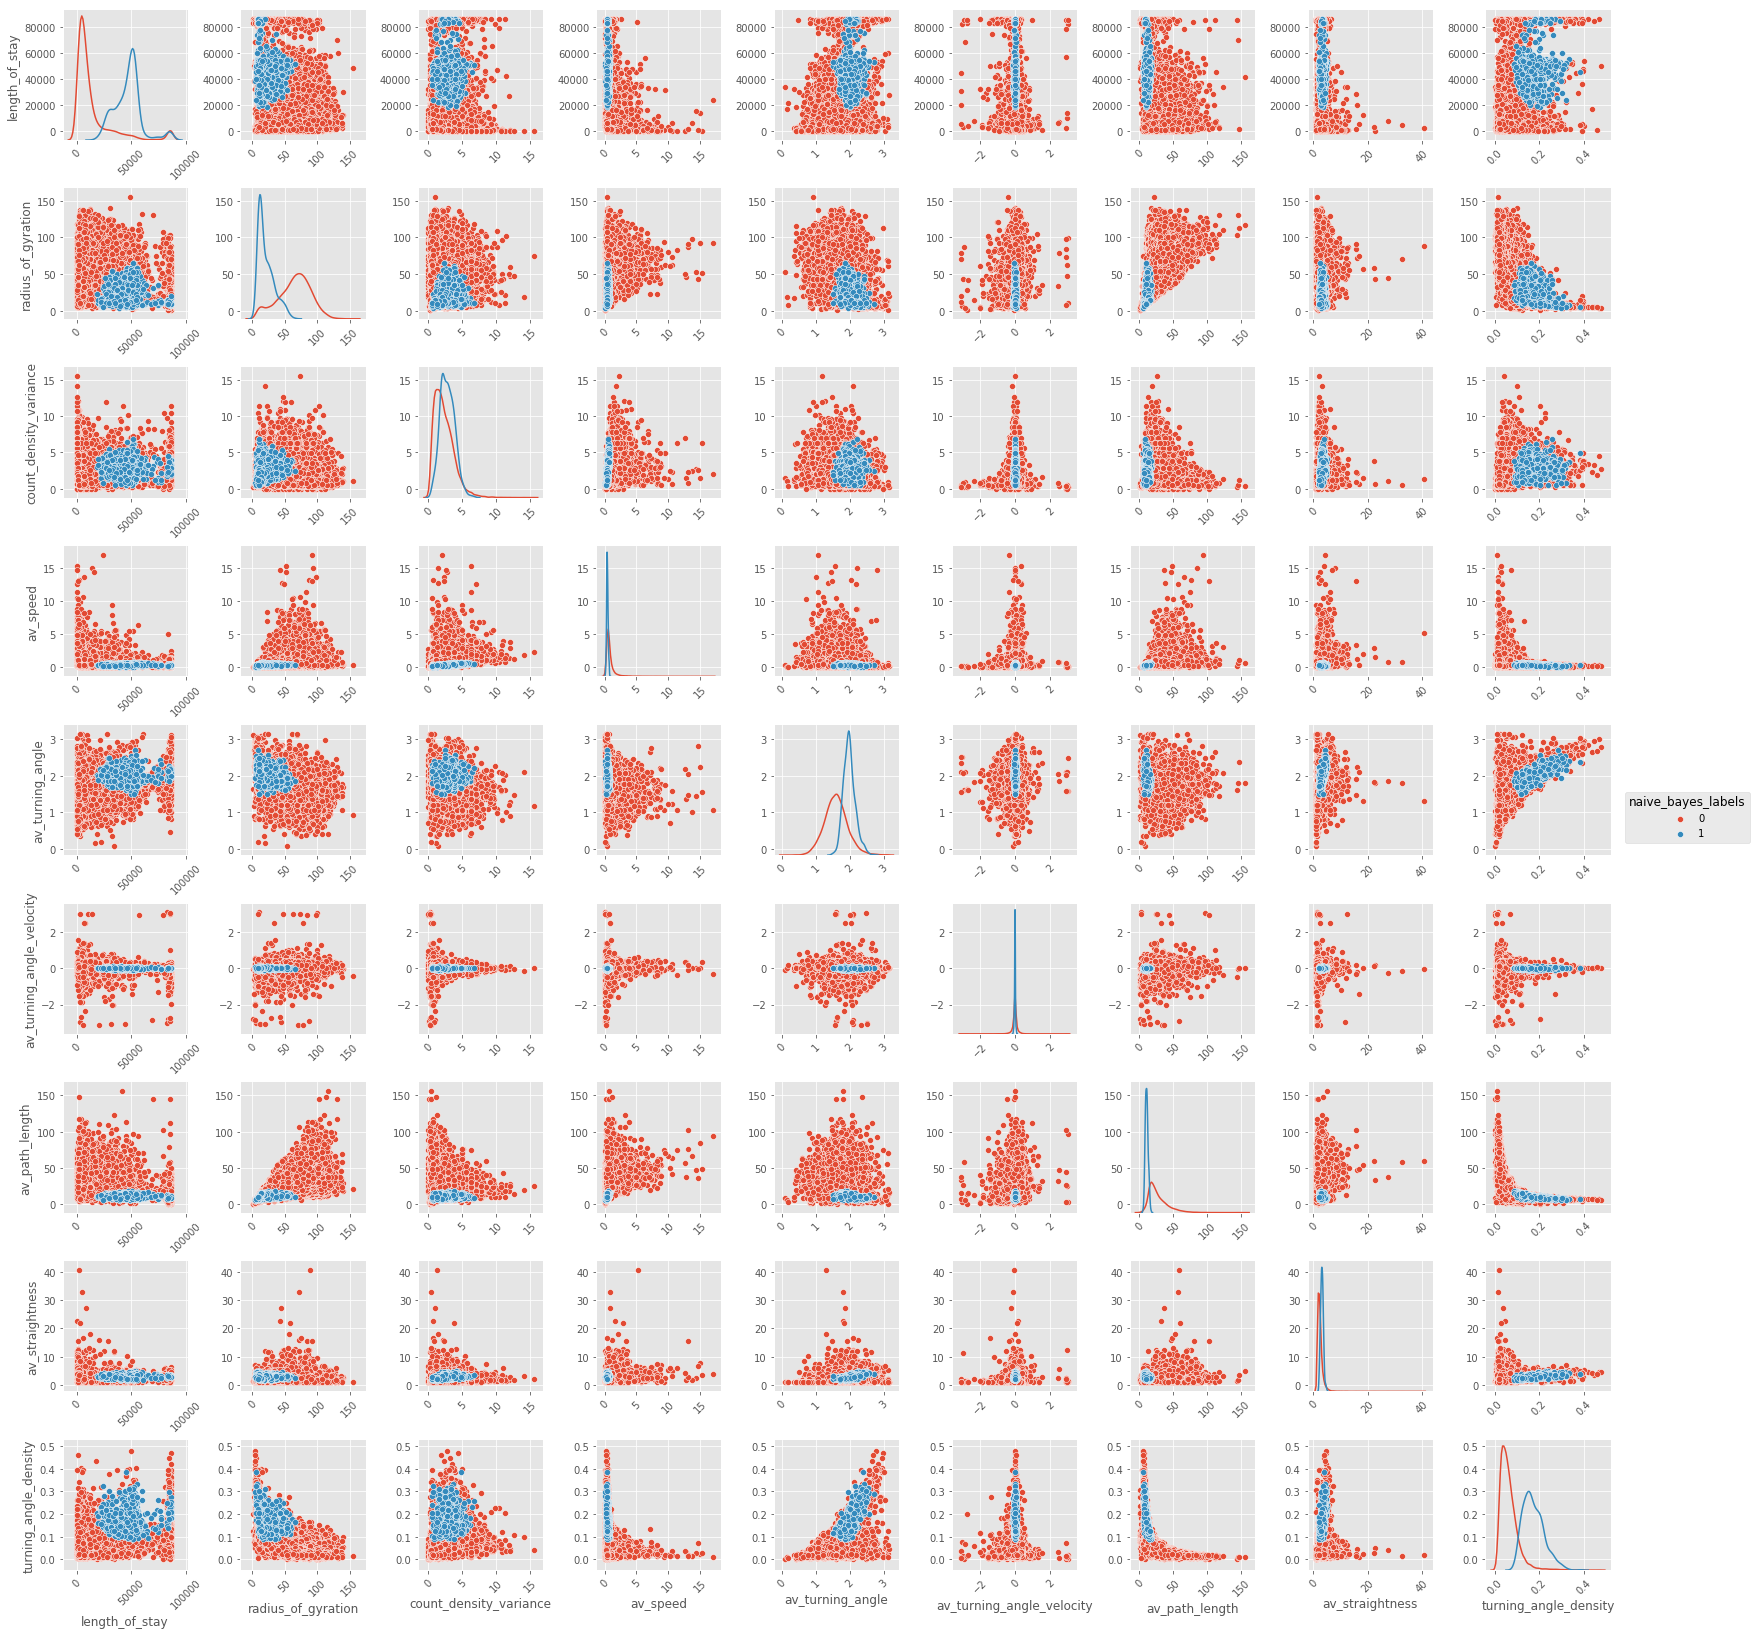

In [144]:
g = sns.pairplot(
    mac_address_clean_df, 
    vars=FEATURE_LIST,
    hue="naive_bayes_labels", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


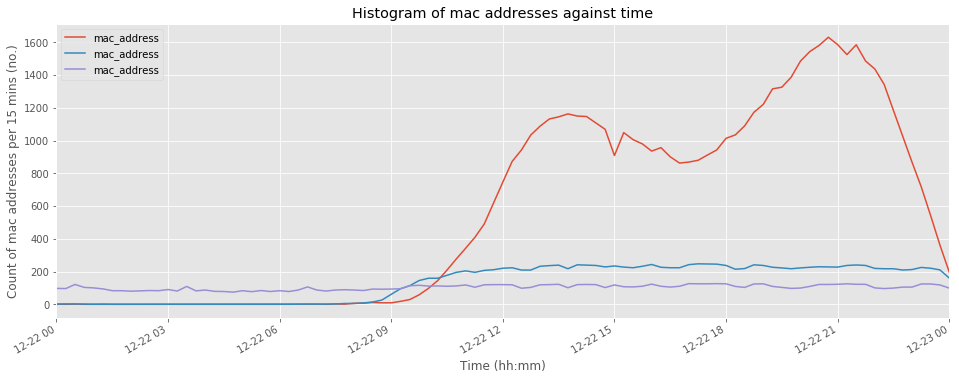

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

macs = mac_address_clean_df[mac_address_clean_df.dbscan_label == 9].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
);

macs = mac_address_clean_df[mac_address_clean_df.dbscan_label == 2].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
);

macs = mac_address_clean_df[mac_address_clean_df.dbscan_label == 1].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
);

## Paths

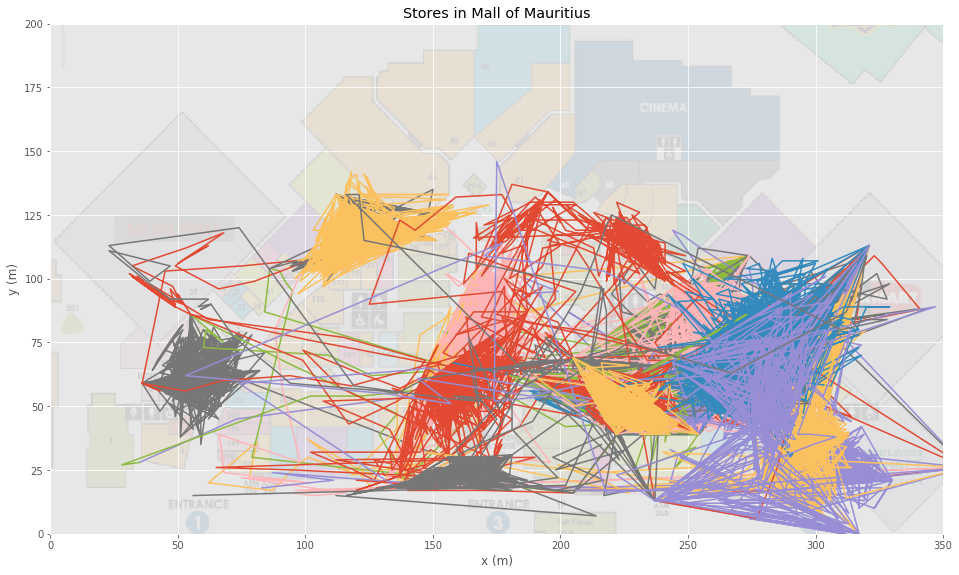

In [169]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_clean_df[mac_address_clean_df.dbscan_label == 2].mac_address.tolist()[20:60],
    axes=ax, 
    scatter=False, 
    label=False
)

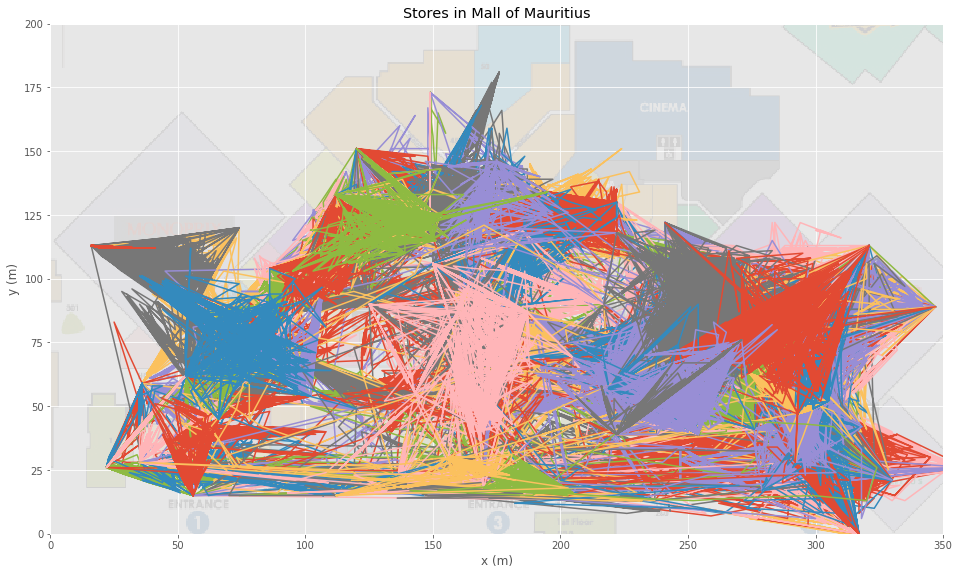

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_clean_df[mac_address_clean_df.naive_bayes_labels == 1].mac_address.tolist(),
    axes=ax, 
    scatter=False, 
    label=False
)

###### Venn Diagrams

In [62]:
k_means_non_shopper_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 1].index.tolist()
gaussian_mixturee_non_shopper_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 1].index.tolist()
out_of_hours_non_shopper_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 1].index.tolist()

In [63]:
k_means_shopper_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 0].index.tolist()
gaussian_mixturee_shopper_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 0].index.tolist()
out_of_hours_shopper_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 0].index.tolist()

Text(0.5,1,'Venn diagram of devices  \n classified as non-shoppers by 2 ML techniques')

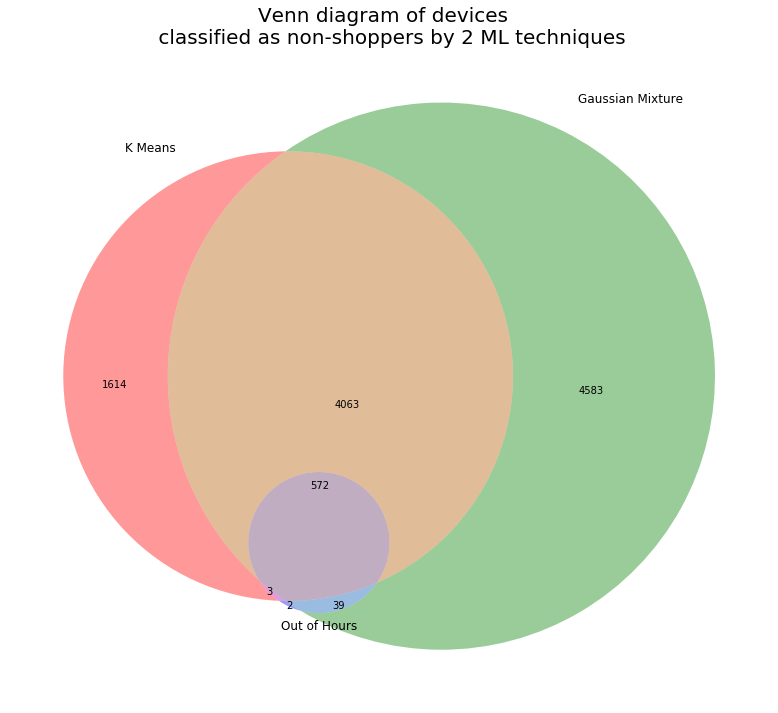

In [64]:
from matplotlib_venn import venn3

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

set1s = set(k_means_non_shopper_index)
set2s = set(gaussian_mixturee_non_shopper_index)
set3s = set(out_of_hours_non_shopper_index)

venn3([set1s, set2s, set3s], ('K Means', 'Gaussian Mixture', 'Out of Hours'), ax=ax1)
ax1.set_title('Venn diagram of devices  \n classified as non-shoppers by 2 ML techniques', fontsize=20)

Almost all of the devices that were out of hours have been classified as non-shoppers. Both clustering methods has given different result.